In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [15]:
def read_csv_replace_missing_by_polynomial(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:, 2:-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 2:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [16]:
df = read_csv_replace_missing_by_polynomial('idh_longevidade.csv')
df = df.T
df
header = df.iloc[0]
df = df[1:]
df.columns = header
df

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
1980,0.523,0.452,0.522,0.531,0.518,0.46,0.561,0.565,0.529,0.516,...,0.56,0.54,0.434,0.527,0.531,0.603,0.592,0.481,0.547,0.522
1991,0.623,0.543,0.627,0.613,0.601,0.595,0.674,0.647,0.636,0.596,...,0.663,0.642,0.593,0.62,0.613,0.685,0.691,0.58,0.673,0.631
2012,0.791,0.749,0.764,0.796,0.79,0.796,0.865,0.863,0.807,0.739,...,0.846,0.832,0.827,0.758,0.752,0.86,0.878,0.775,0.863,0.785
2013,0.797,0.756,0.769,0.801,0.794,0.801,0.87,0.87,0.81,0.744,...,0.852,0.837,0.831,0.762,0.757,0.865,0.885,0.779,0.869,0.79
2014,0.804,0.763,0.773,0.806,0.799,0.804,0.875,0.876,0.813,0.749,...,0.857,0.843,0.836,0.765,0.763,0.87,0.89,0.784,0.875,0.795
2015,0.809,0.769,0.777,0.811,0.803,0.808,0.879,0.882,0.815,0.754,...,0.862,0.848,0.84,0.769,0.768,0.875,0.896,0.788,0.88,0.8
2016,0.815,0.776,0.781,0.815,0.807,0.812,0.884,0.887,0.818,0.759,...,0.867,0.853,0.844,0.772,0.774,0.88,0.902,0.793,0.885,0.805
2017,0.82,0.782,0.785,0.82,0.811,0.816,0.888,0.892,0.821,0.764,...,0.872,0.858,0.848,0.775,0.779,0.884,0.907,0.797,0.889,0.809
2018,0.825,0.788,0.789,0.824,0.815,0.819,0.892,0.897,0.824,0.769,...,0.877,0.863,0.851,0.778,0.784,0.888,0.912,0.801,0.894,0.814
2019,0.83,0.793,0.792,0.828,0.818,0.823,0.896,0.902,0.827,0.773,...,0.882,0.867,0.855,0.781,0.788,0.893,0.916,0.805,0.898,0.818


In [17]:
df['Ano'] = df.index
df = df.reset_index(drop=True)

missing_years = list(range(1981, 1991)) + list(range(1992, 2012)) + list(range(2022,2023))
for year in missing_years: 
    novo_ano = pd.Series({'Ano': year})
    df = df.append(novo_ano, ignore_index=True)
    
df['Ano'] = df['Ano'].astype(int)    
df = df.sort_values('Ano', ascending=True)
df = df.set_index('Ano')
df.to_csv('idh_para_interpolacao.csv', index=True)
df

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.523,0.452,0.522,0.531,0.518,0.46,0.561,0.565,0.529,0.516,...,0.56,0.54,0.434,0.527,0.531,0.603,0.592,0.481,0.547,0.522
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
def read_csv_replace_missing_by_polynomial_2(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

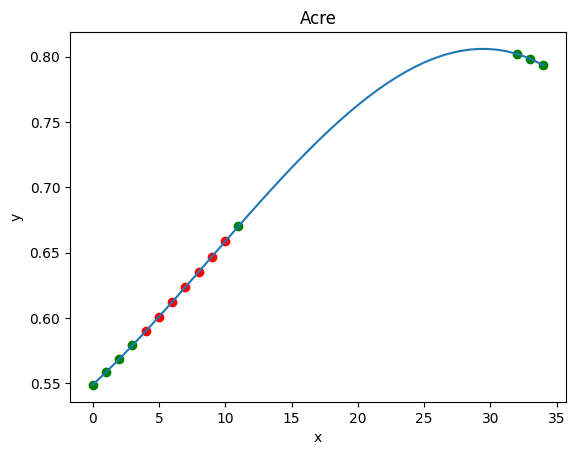

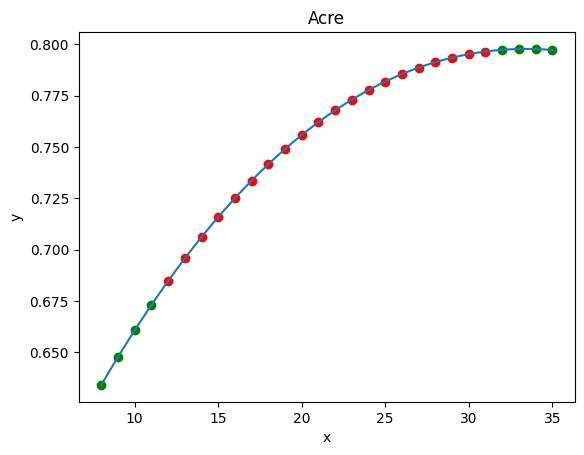

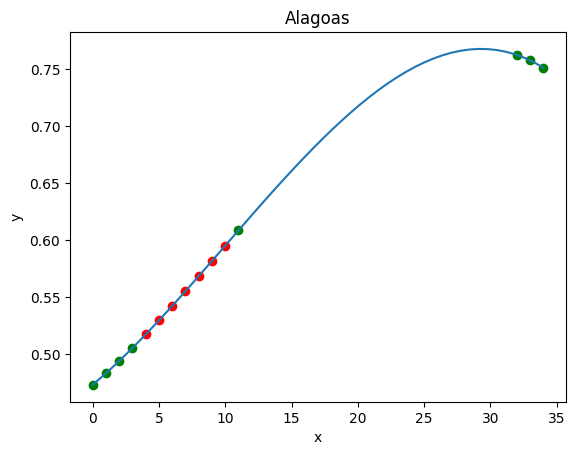

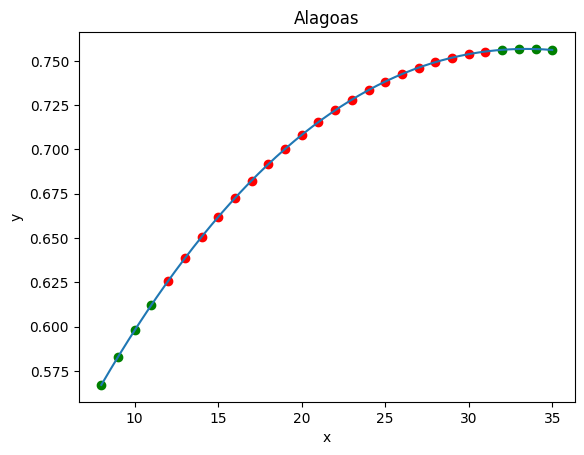

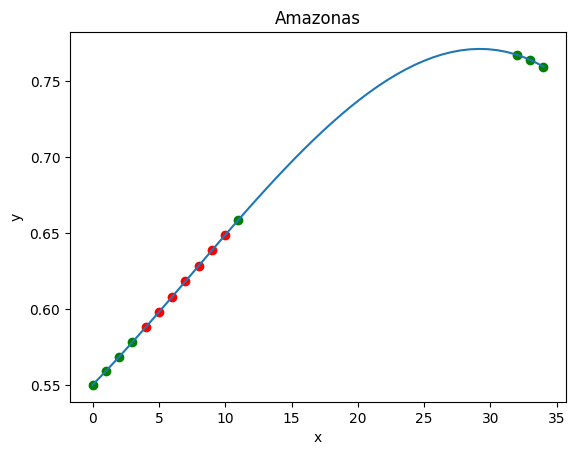

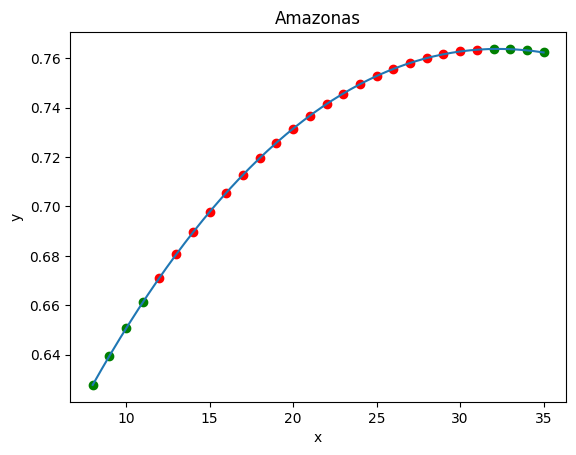

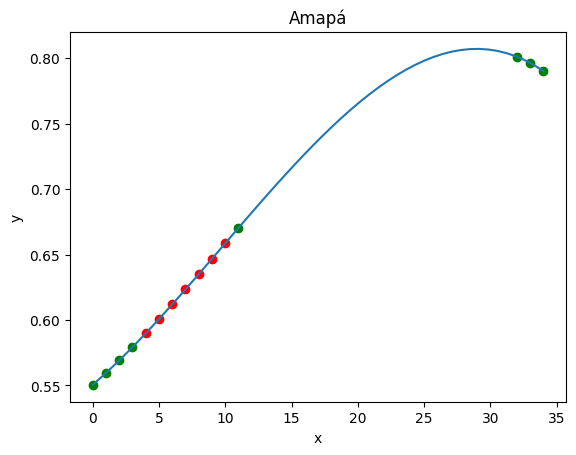

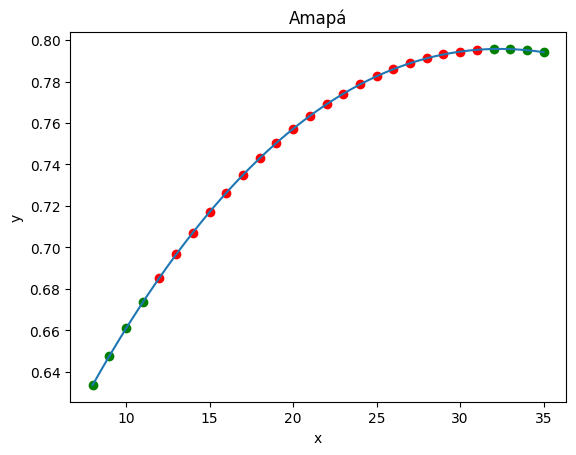

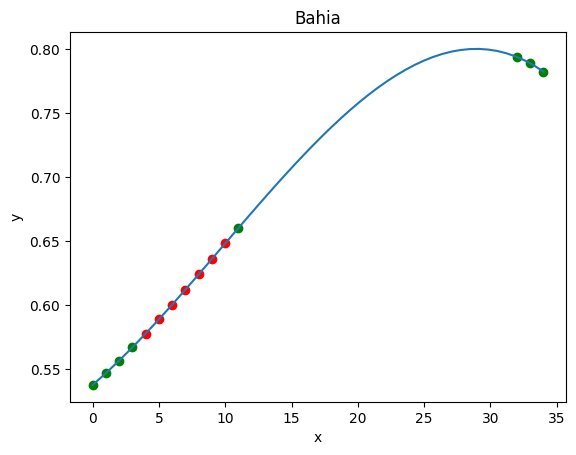

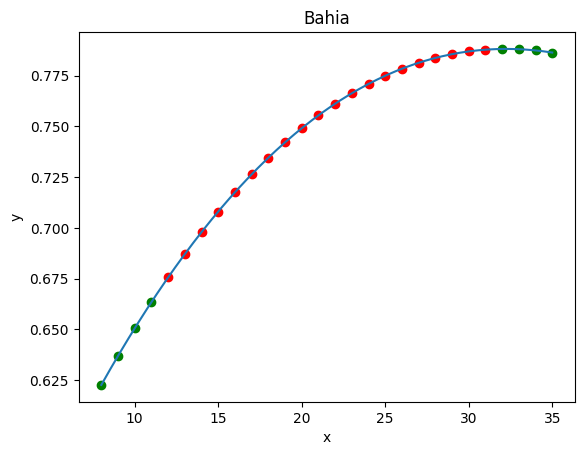

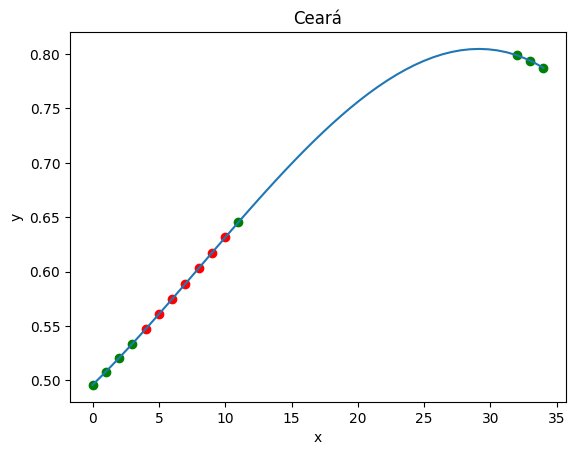

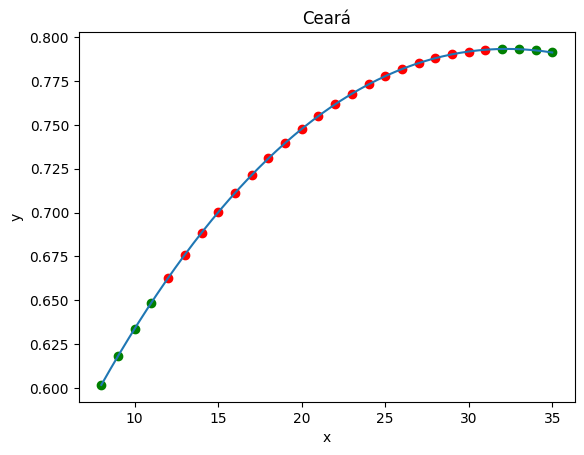

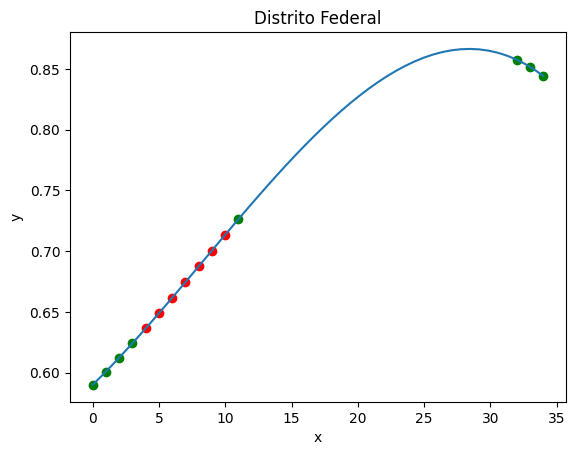

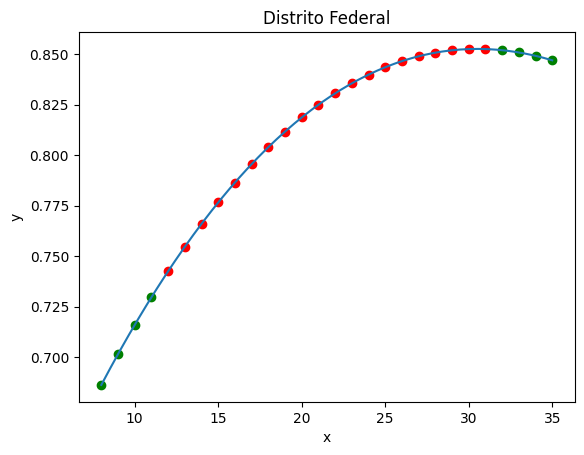

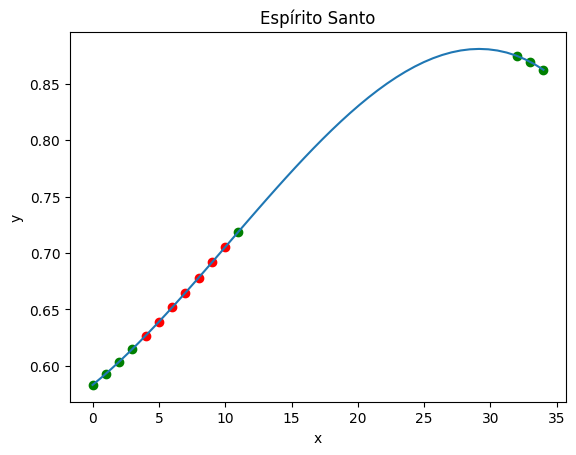

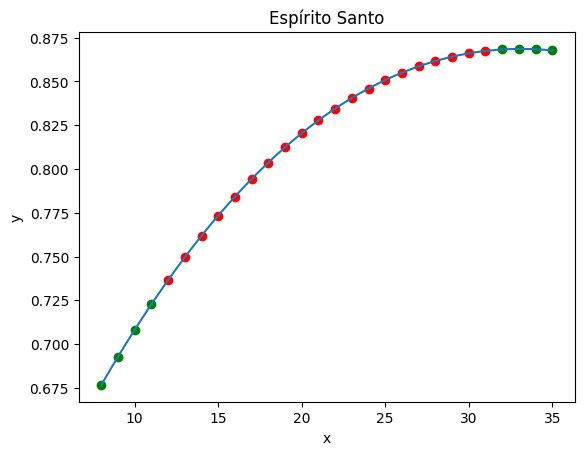

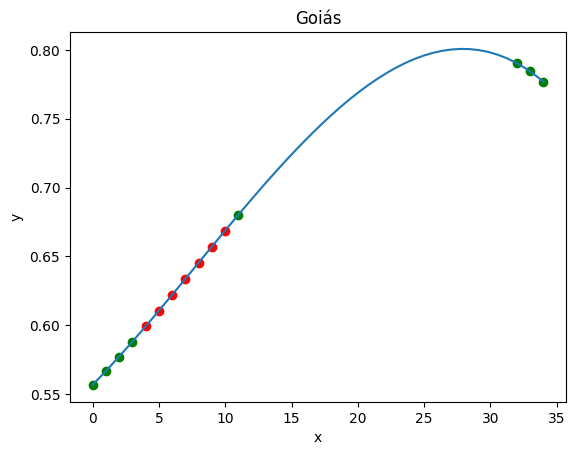

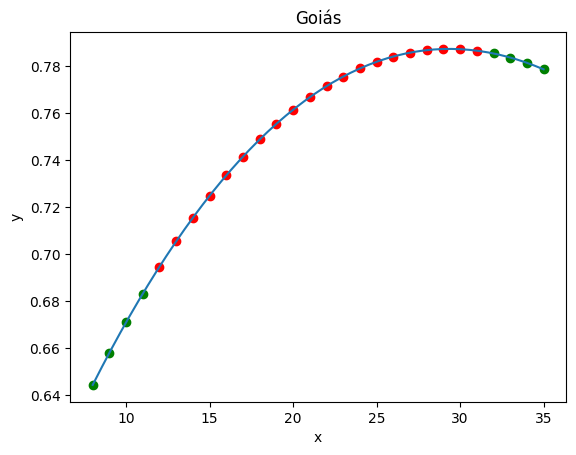

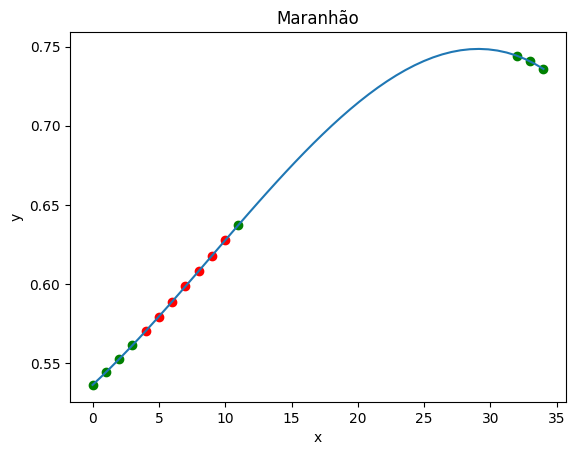

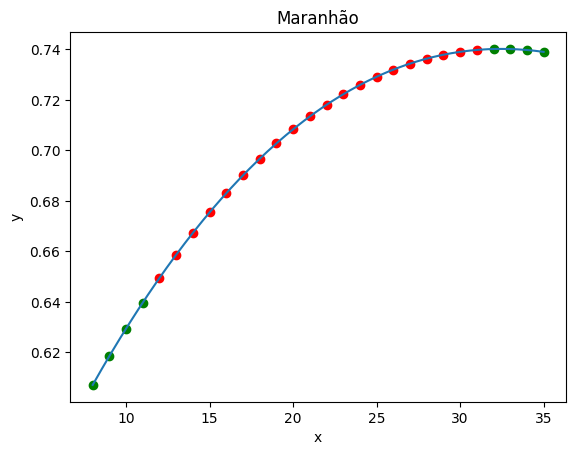

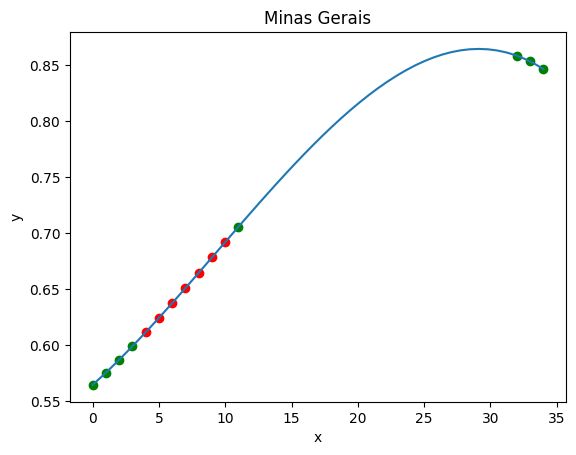

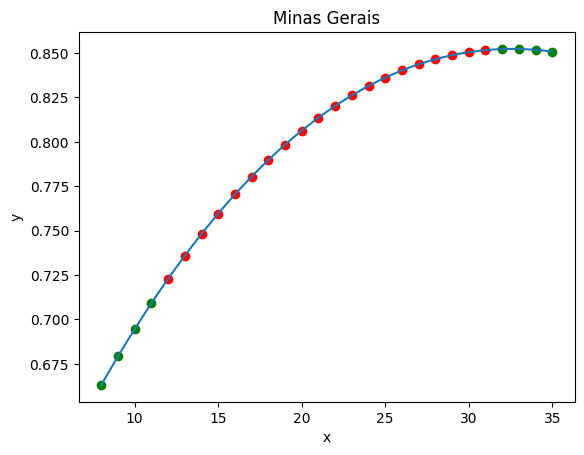

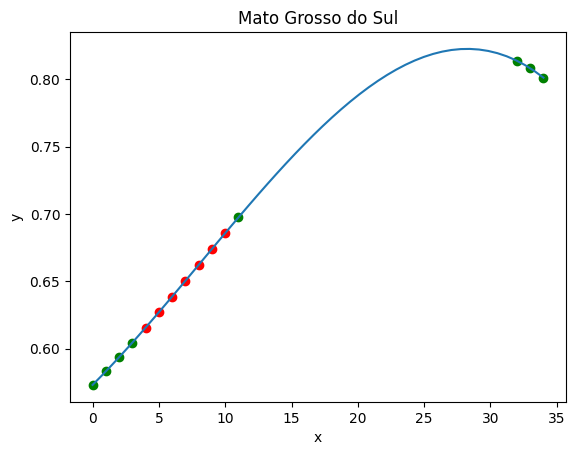

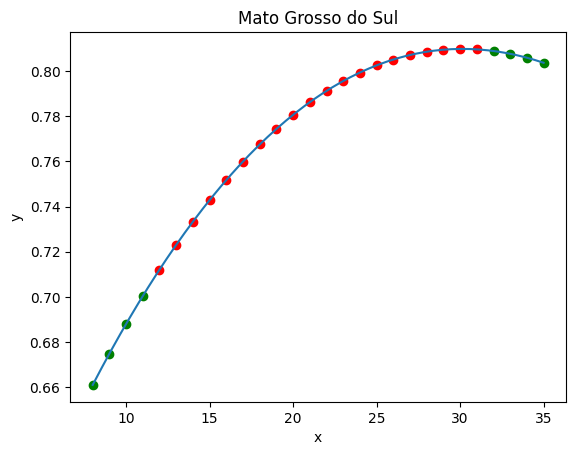

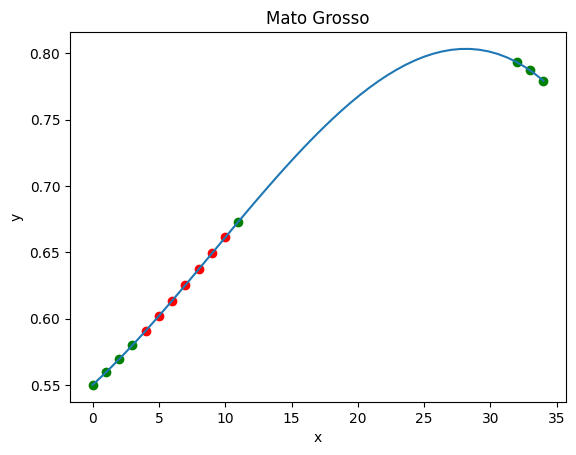

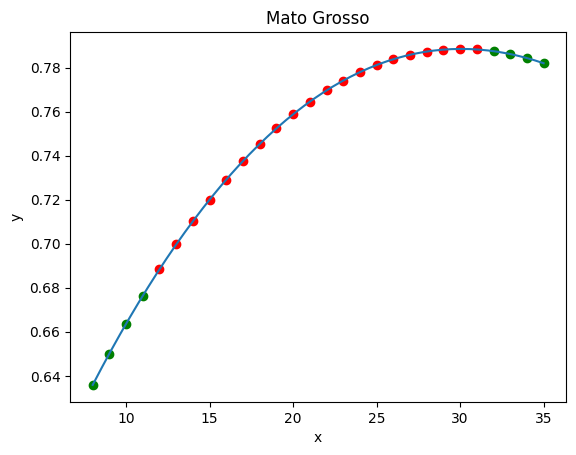

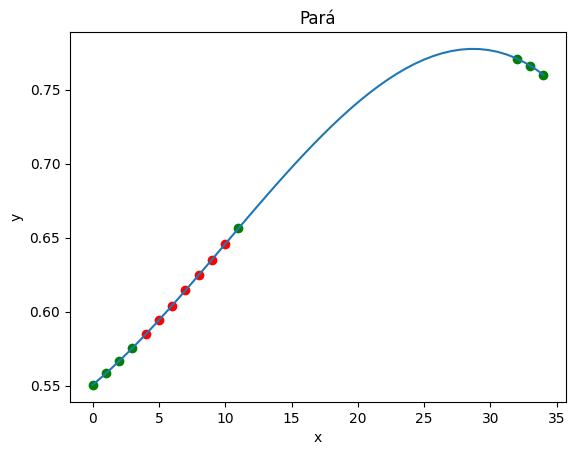

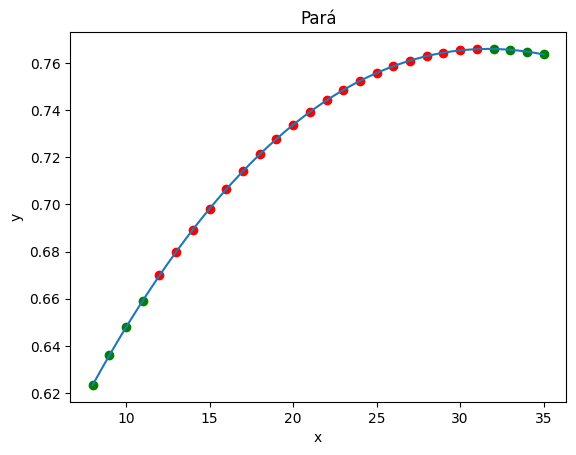

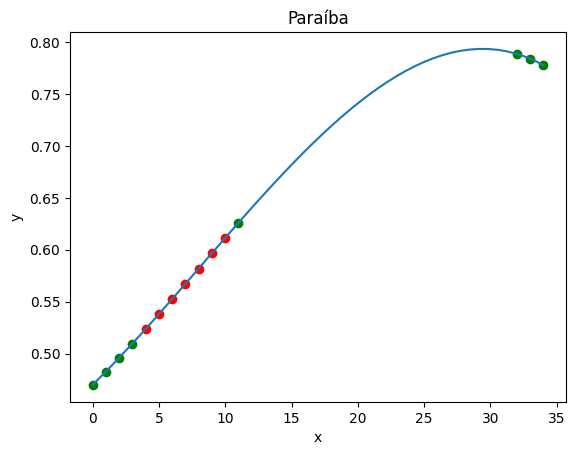

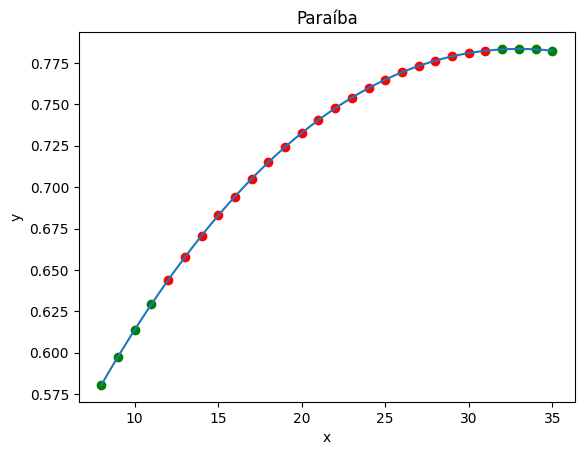

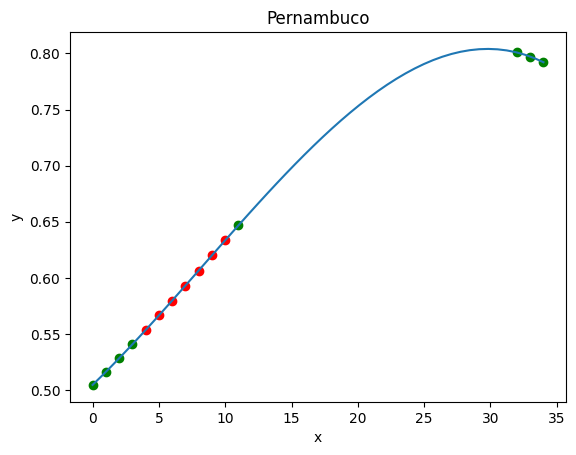

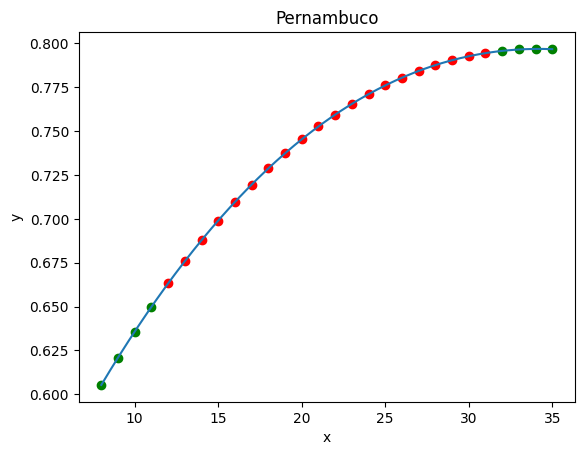

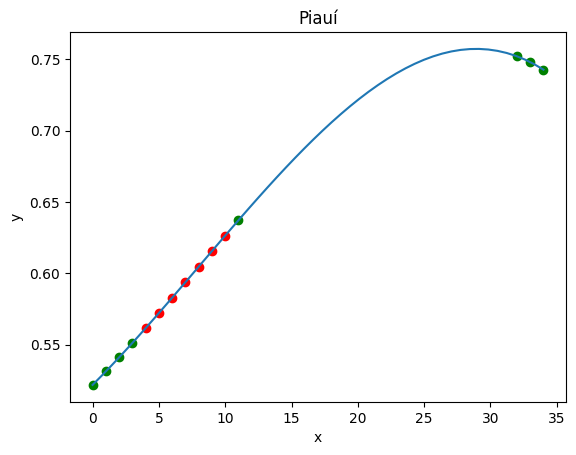

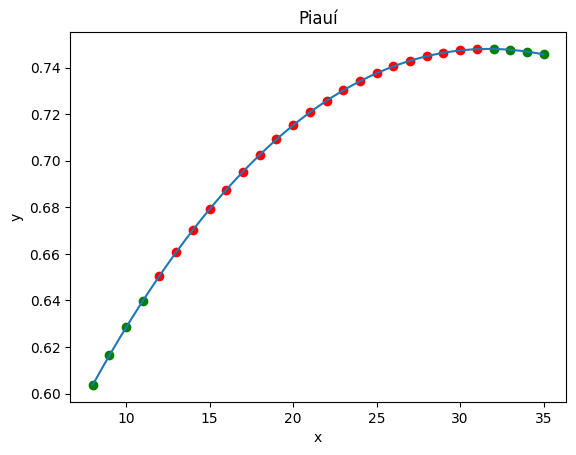

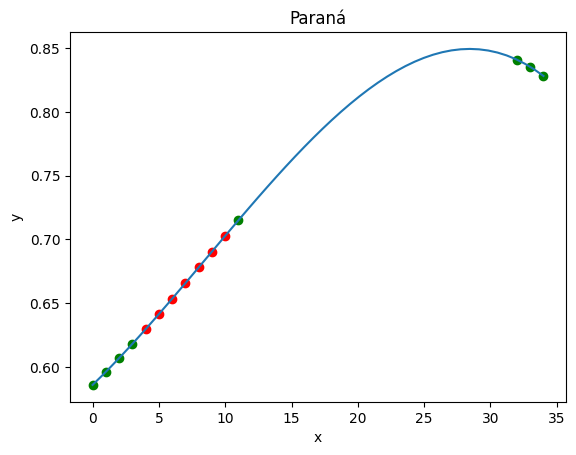

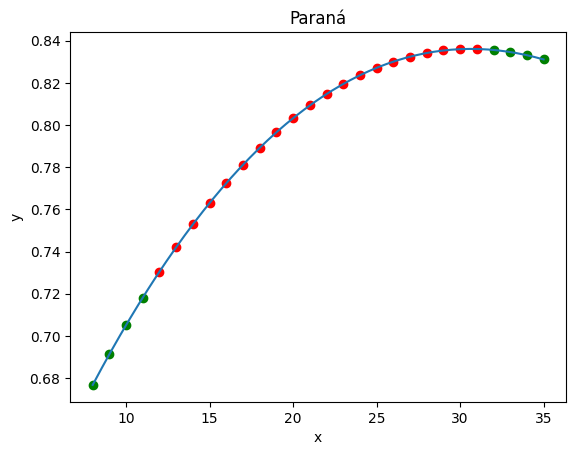

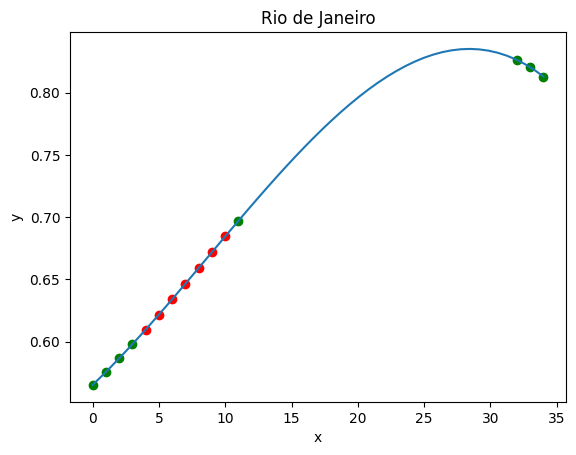

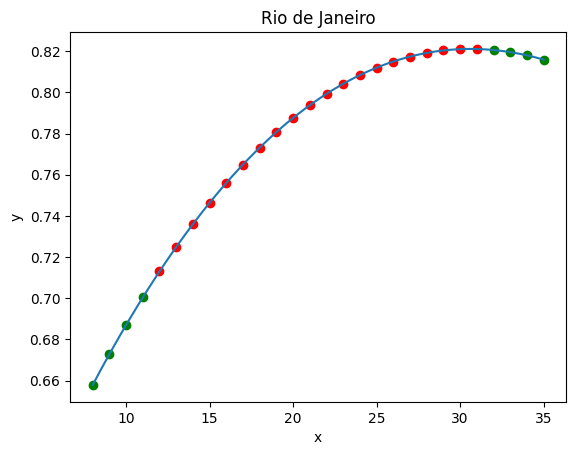

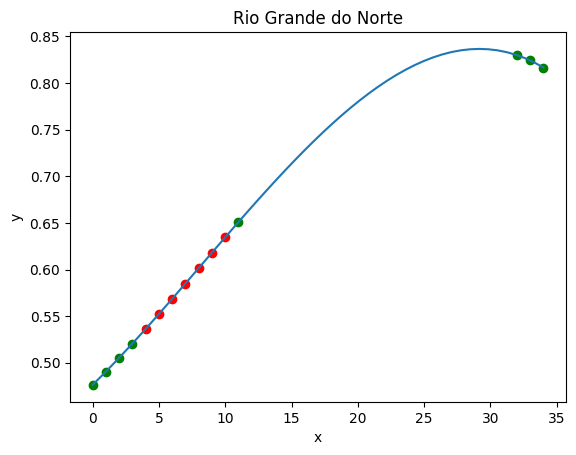

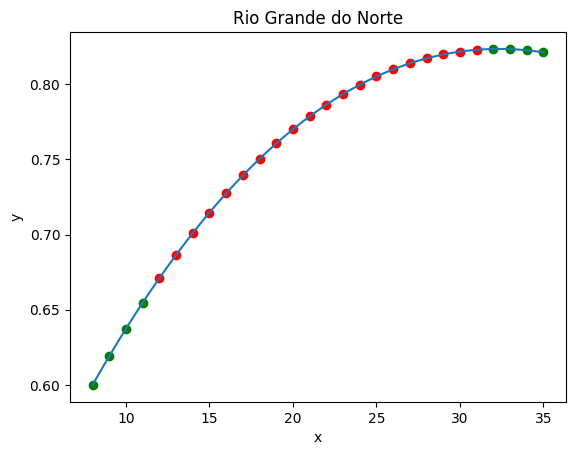

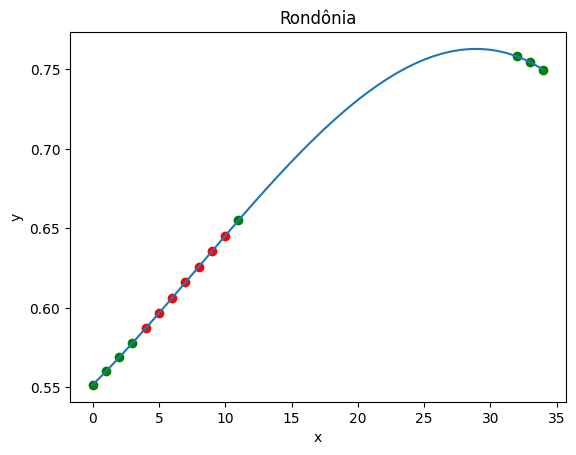

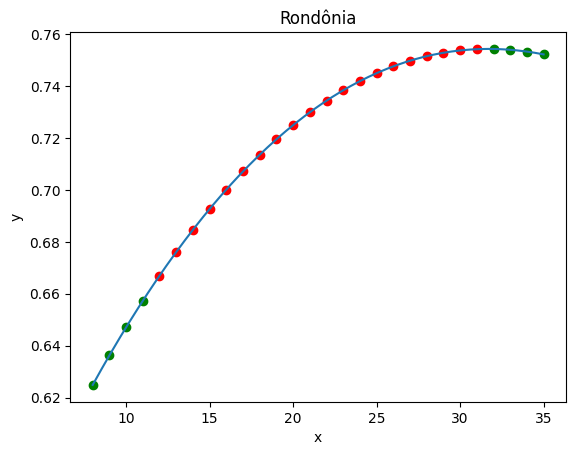

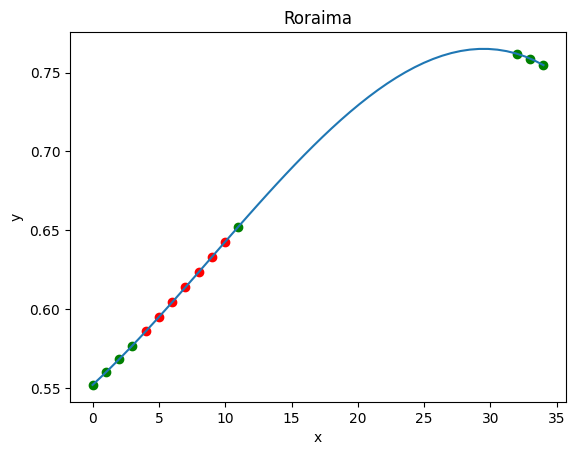

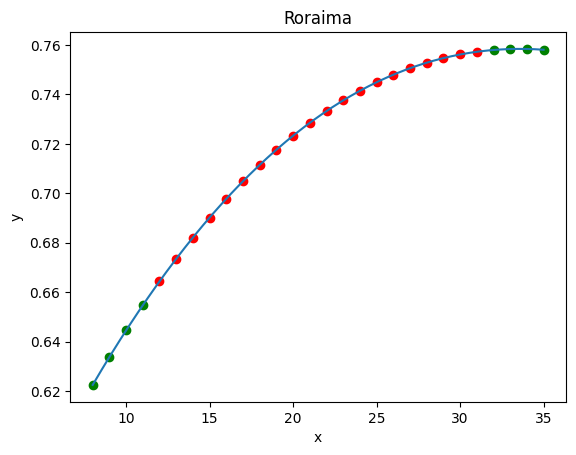

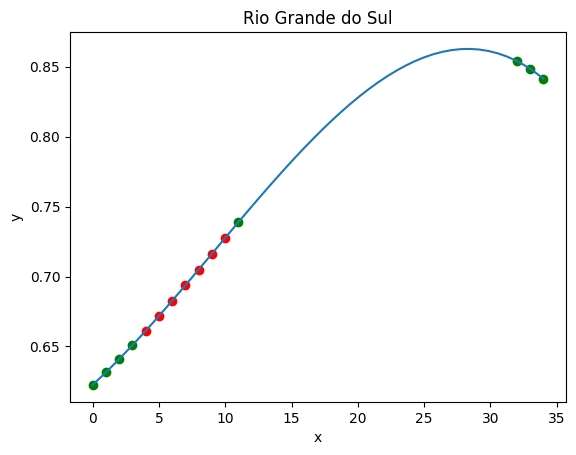

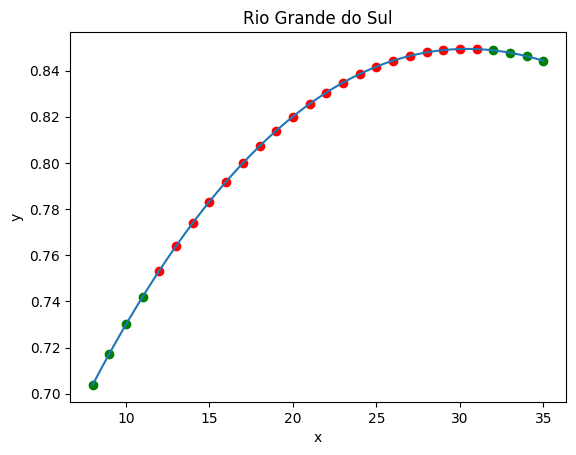

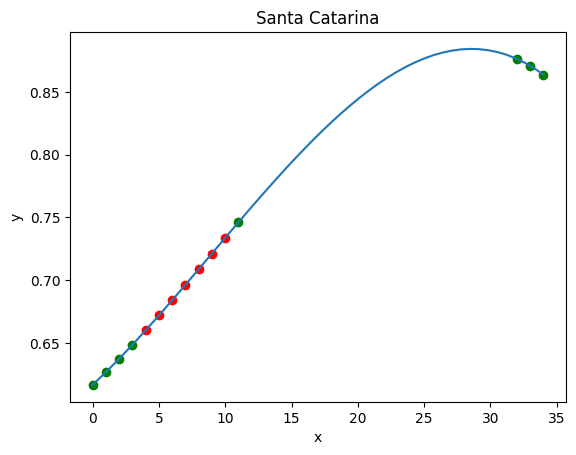

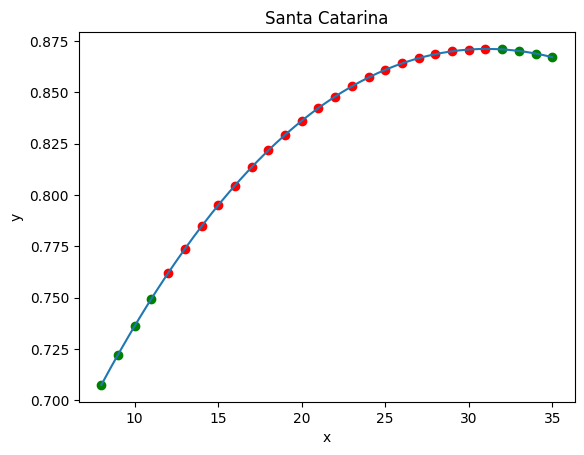

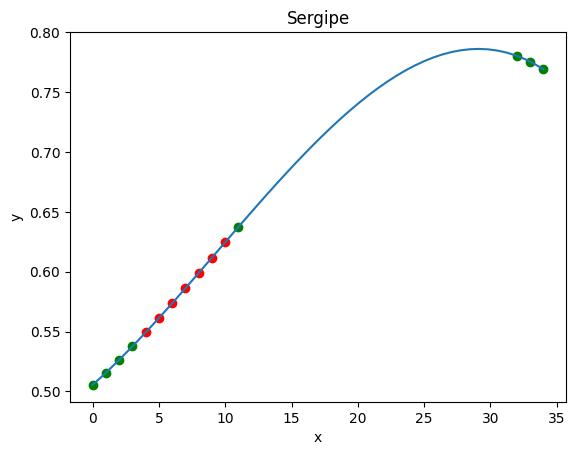

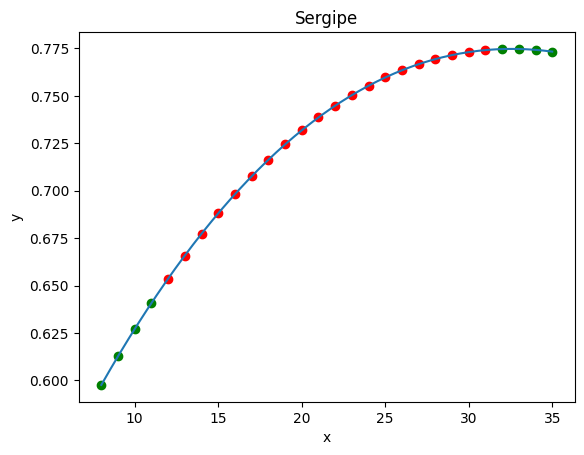

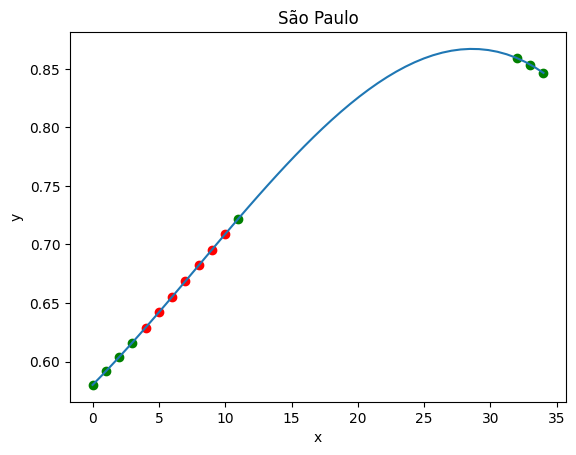

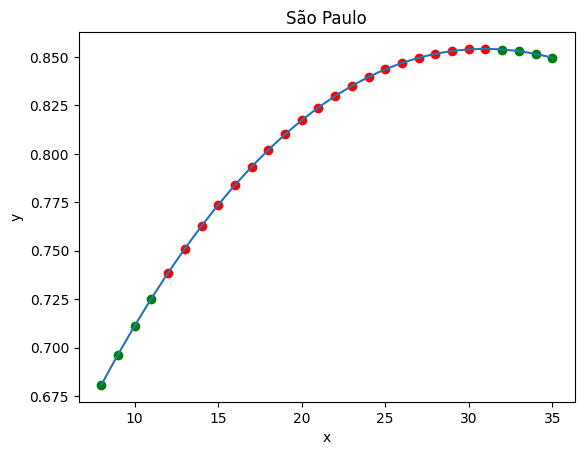

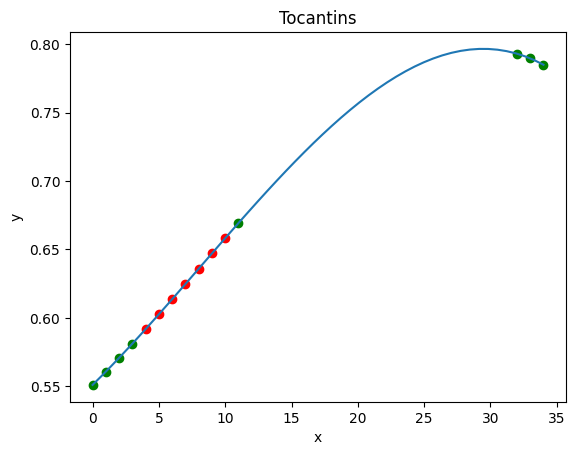

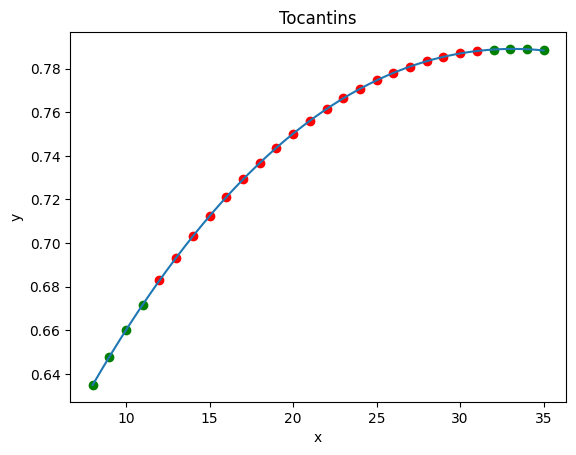

,Acre - IDH Longevidade,Alagoas - IDH Longevidade,Amazonas - IDH Longevidade,Amapá - IDH Longevidade,Bahia - IDH Longevidade,Ceará - IDH Longevidade,Distrito Federal - IDH Longevidade,Espírito Santo - IDH Longevidade,Goiás - IDH Longevidade,Maranhão - IDH Longevidade,...,Paraná - IDH Longevidade,Rio de Janeiro - IDH Longevidade,Rio Grande do Norte - IDH Longevidade,Rondônia - IDH Longevidade,Roraima - IDH Longevidade,Rio Grande do Sul - IDH Longevidade,Santa Catarina - IDH Longevidade,Sergipe - IDH Longevidade,São Paulo - IDH Longevidade,Tocantins - IDH Longevidade
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.553909,0.480127,0.554455,0.556345,0.543655,0.501727,0.595927,0.590345,0.562073,0.540727,...,0.591836,0.571527,0.483145,0.555745,0.556345,0.628345,0.622600,0.511600,0.585945,0.555691
1981,0.560091,0.485753,0.560945,0.561415,0.548785,0.510073,0.602913,0.595415,0.568687,0.545673,...,0.598204,0.577833,0.492975,0.561495,0.561415,0.633415,0.628720,0.517720,0.593735,0.562429
1982,0.565691,0.490849,0.566825,0.566007,0.553433,0.517633,0.609241,0.600007,0.574679,0.550153,...,0.603972,0.583545,0.501879,0.566703,0.566007,0.638007,0.634264,0.523264,0.600791,0.568533
1983,0.570593,0.495309,0.571972,0.570026,0.557502,0.524250,0.614780,0.604026,0.579924,0.554074,...,0.609021,0.588545,0.509672,0.571261,0.570026,0.642026,0.639117,0.528117,0.606967,0.573876
1984,0.589660,0.517508,0.588273,0.589692,0.577629,0.547101,0.636348,0.626763,0.599303,0.570156,...,0.629639,0.609741,0.536267,0.587153,0.585814,0.661178,0.660018,0.549270,0.629005,0.591832
1985,0.600763,0.529804,0.598249,0.600609,0.588785,0.560816,0.648852,0.639078,0.610661,0.579396,...,0.641460,0.621794,0.552276,0.596640,0.594985,0.671805,0.671872,0.561305,0.642049,0.602669
1986,0.612091,0.542460,0.608339,0.611833,0.600261,0.574750,0.661582,0.651804,0.622189,0.588833,...,0.653512,0.634098,0.568533,0.606272,0.604343,0.682696,0.683986,0.573637,0.655285,0.613664
1987,0.623586,0.555404,0.618498,0.623299,0.611991,0.588839,0.674472,0.664864,0.633831,0.598419,...,0.665734,0.646587,0.584963,0.616001,0.613843,0.693786,0.696293,0.586202,0.668651,0.624767
1988,0.635194,0.568564,0.628684,0.634944,0.623908,0.603015,0.687456,0.678181,0.645528,0.608104,...,0.678060,0.659197,0.601490,0.625783,0.623437,0.705014,0.708730,0.598931,0.682081,0.635930


In [19]:
df = read_csv_replace_missing_by_polynomial_2('idh_para_interpolacao.csv')
df = df.set_index('Ano')
df.columns = df.columns + ' - IDH Longevidade'
df

In [20]:
df_2014 = df[df.index >= 2014]
df_2014

,Acre - IDH Longevidade,Alagoas - IDH Longevidade,Amazonas - IDH Longevidade,Amapá - IDH Longevidade,Bahia - IDH Longevidade,Ceará - IDH Longevidade,Distrito Federal - IDH Longevidade,Espírito Santo - IDH Longevidade,Goiás - IDH Longevidade,Maranhão - IDH Longevidade,...,Paraná - IDH Longevidade,Rio de Janeiro - IDH Longevidade,Rio Grande do Norte - IDH Longevidade,Rondônia - IDH Longevidade,Roraima - IDH Longevidade,Rio Grande do Sul - IDH Longevidade,Santa Catarina - IDH Longevidade,Sergipe - IDH Longevidade,São Paulo - IDH Longevidade,Tocantins - IDH Longevidade
Ano,,,,,,,,,,,,,,,,,,,,,
2014,0.797827,0.756698,0.763162,0.795157,0.787476,0.792439,0.849205,0.868413,0.781434,0.739796,...,0.833112,0.818048,0.822577,0.753246,0.758460,0.846291,0.868970,0.774272,0.851595,0.788936
2015,0.797313,0.756172,0.762342,0.794254,0.786515,0.791476,0.847056,0.867781,0.778804,0.739029,...,0.831122,0.815969,0.821459,0.752267,0.758081,0.844315,0.867217,0.773462,0.849644,0.788430
2016,0.807377,0.767870,0.770069,0.803514,0.796009,0.802758,0.854633,0.879440,0.784027,0.746544,...,0.838386,0.823363,0.834707,0.759242,0.766432,0.850637,0.875108,0.784003,0.857989,0.797827
2017,0.806684,0.767131,0.769075,0.802470,0.795010,0.801917,0.851963,0.878752,0.780939,0.745411,...,0.835784,0.820668,0.833862,0.758083,0.765744,0.847968,0.872664,0.783185,0.855534,0.797174
2018,0.805473,0.765779,0.767627,0.800876,0.793556,0.800637,0.848687,0.877548,0.777297,0.743721,...,0.832492,0.817275,0.832577,0.756545,0.764538,0.844692,0.869542,0.781929,0.852491,0.796099
2019,0.803698,0.763759,0.765684,0.798774,0.791607,0.798968,0.844750,0.875780,0.773051,0.741423,...,0.828446,0.813118,0.830902,0.754594,0.762769,0.840755,0.865683,0.780196,0.848718,0.794472
2020,0.801307,0.761101,0.763292,0.796117,0.789208,0.796783,0.840091,0.873396,0.768147,0.738553,...,0.823577,0.808219,0.828711,0.752194,0.760476,0.836006,0.861108,0.777941,0.844237,0.792333
2021,0.799153,0.758837,0.761500,0.794401,0.787227,0.794491,0.840462,0.871432,0.768615,0.736785,...,0.823903,0.808603,0.826321,0.750575,0.758428,0.836461,0.861391,0.775662,0.844259,0.790091
2022,0.800167,0.759822,0.763091,0.795892,0.788611,0.795444,0.843868,0.872108,0.772943,0.738765,...,0.827439,0.812203,0.826987,0.752354,0.759649,0.840048,0.864517,0.776723,0.847373,0.791099


In [21]:
for column in df_2014.columns:
    state = column
    file_name = f"2014_01_idh_long_{state}.csv"
    column_df = df_2014[[column]]
    column_df.to_csv(file_name, index=True)

In [22]:
df_2008 = df[df.index >= 2008]
df_2008

,Acre - IDH Longevidade,Alagoas - IDH Longevidade,Amazonas - IDH Longevidade,Amapá - IDH Longevidade,Bahia - IDH Longevidade,Ceará - IDH Longevidade,Distrito Federal - IDH Longevidade,Espírito Santo - IDH Longevidade,Goiás - IDH Longevidade,Maranhão - IDH Longevidade,...,Paraná - IDH Longevidade,Rio de Janeiro - IDH Longevidade,Rio Grande do Norte - IDH Longevidade,Rondônia - IDH Longevidade,Roraima - IDH Longevidade,Rio Grande do Sul - IDH Longevidade,Santa Catarina - IDH Longevidade,Sergipe - IDH Longevidade,São Paulo - IDH Longevidade,Tocantins - IDH Longevidade
Ano,,,,,,,,,,,,,,,,,,,,,
2008,0.791356,0.749235,0.760020,0.791218,0.783758,0.788078,0.850754,0.861639,0.786865,0.736322,...,0.834122,0.819163,0.817253,0.751494,0.752834,0.847908,0.868622,0.769402,0.851565,0.783419
2009,0.793548,0.751769,0.761567,0.793078,0.785624,0.790273,0.851939,0.864109,0.787352,0.737873,...,0.835310,0.820366,0.819840,0.752810,0.754681,0.848897,0.870023,0.771521,0.853009,0.785421
2010,0.795275,0.753767,0.762693,0.794442,0.786978,0.791872,0.852532,0.866025,0.787273,0.739020,...,0.835940,0.820996,0.821734,0.753706,0.756148,0.849366,0.870869,0.773103,0.853860,0.786976
2011,0.796547,0.755240,0.763406,0.795319,0.787829,0.792885,0.852542,0.867397,0.786636,0.739772,...,0.836020,0.821062,0.822949,0.754192,0.757242,0.849325,0.871172,0.774160,0.854127,0.788093
2012,0.797243,0.756056,0.763641,0.795637,0.788133,0.793321,0.851897,0.868109,0.785429,0.740034,...,0.835445,0.820467,0.823515,0.754233,0.757859,0.848674,0.870803,0.774664,0.853708,0.788709
2013,0.797764,0.756644,0.763611,0.795607,0.787978,0.793098,0.850805,0.868535,0.783632,0.740120,...,0.834565,0.819506,0.823225,0.753919,0.758347,0.847730,0.870203,0.774636,0.852933,0.789018
2014,0.797827,0.756698,0.763162,0.795157,0.787476,0.792439,0.849205,0.868413,0.781434,0.739796,...,0.833112,0.818048,0.822577,0.753246,0.758460,0.846291,0.868970,0.774272,0.851595,0.788936
2015,0.797313,0.756172,0.762342,0.794254,0.786515,0.791476,0.847056,0.867781,0.778804,0.739029,...,0.831122,0.815969,0.821459,0.752267,0.758081,0.844315,0.867217,0.773462,0.849644,0.788430
2016,0.807377,0.767870,0.770069,0.803514,0.796009,0.802758,0.854633,0.879440,0.784027,0.746544,...,0.838386,0.823363,0.834707,0.759242,0.766432,0.850637,0.875108,0.784003,0.857989,0.797827


In [23]:
for column in df_2008.columns:
    state = column
    file_name = f"2008_01_idh_long_{state}.csv"
    column_df = df_2008[[column]]
    column_df.to_csv(file_name, index=True)